## Section 1: Introduction

In this notebook I carry out a multiple linear regression of the condition of Texas bridges using predictors: bridge age, average vehicle traffic, percentage of trucks, bridge material, and bridge design; from Texas Department of Transportation bridge data. The goal of the analysis is to understand the effects of the predictor variables on the condition of bridges in the dataset. The analysis involves three phases: Data Preparation, Exploratory Analysis, and Regression Analysis.


### Section 1.1: Outline

In Section 2, I explore and prepare the data in the predictor variables, removing outliers from the age variable, consolidating classes in the materials and design variables, and deriving a current condition target variable from the existing bridge rating variables (deck rating, superstructure rating, and substructure rating). In Section 3, I use plots to compare continuous variables to one another, continous to categorical variables, and categorical variables to one another to get an initial sense of any associations between the variables used in the analysis. In Section 4, I conduct the linear regression, explore the model fit, the quality of the model, interpret the results and draw conclusions about the impact of the predictor variables on current condition.


### Section 1.2: Loading the Data
The data is loaded from a CSV file ('tx19_bridges_sample.csv').

**Variables Relevant to the Analysis from the Original Dataframe:**

| Variable      |      Description             | Type | 
|:--------------|:-----------------------------|:------:|
|Structure_id   | Unique identifier of the bridge                  | String |
|Year           | The year the bridge was built                             | continuous |
|AverageDaily   | The average daily traffic (number of vehicles)            | continuous |
|Trucks_percent | The percent of traffic made up of 'trucks' (i.e. lorries) | continuous |
|Material       | The dominant material the bridge is made from             | category |
|Design         | The design of the bridge                                  | category |
|Deck_rating    | The condition of the deck of the bridge                   | ordinal |
|Superstr_rating| The condition of the bridge superstructure                | ordinal |
|Substr_rating  | The condition of the bridge substructure (foundations)    | ordinal |

In [1]:
import pandas as pd

rating_type = pd.CategoricalDtype(
    categories=['Failed', 'Failing', 'Critical', 'Serious', 'Poor', 'Fair', 
                'Satisfactory', 'Good', 'Very Good', 'Excellent', 'NA'], 
    ordered=True)

scour_type = pd.CategoricalDtype(
    categories=['Unknown', 'Critical','Unstable', 'Stable', 'Protected', 'Dry', 'No waterway'], 
    ordered=True)

types_dict = { 'Structure_id': str, 'District':'category', 'Toll':'category', 
              'Maintainer':'category', 'Urban':'category', 'Status':'category', 
              'Historic':'category', 'Service_under':'category', 'Material':'category', 
              'Design':'category', 
              'Deck_rating':rating_type, 'Superstr_rating':rating_type, 'Substr_rating':rating_type, 
              'Scour_rating':scour_type}

bridges = pd.read_csv('tx19_bridges_sample.csv', dtype = types_dict, index_col = 'Structure_id')
bridges

,District,Detour_Km,Toll,Maintainer,Urban,Status,Year,Lanes_on,Lanes_under,AverageDaily,...,Spans,Length,Width,Deck_rating,Superstr_rating,Substr_rating,Rated_load,Trucks_percent,Scour_rating,Future_traffic
Structure_id,,,,,,,,,,,,,,,,,,,,,
000021521-00101,District2,199,Free,Agency,Rural,Local,2005,1,0,1,...,2,31.4,4.3,Good,Very Good,Very Good,41.7,0.0,Dry,1
000021521-00181,District2,199,Free,Agency,Rural,Local,2005,1,0,1,...,1,15.5,4.3,Good,Good,Very Good,41.7,0.0,Dry,1
000021521-TMP20,District2,199,Free,Agency,Rural,Local,2012,2,0,100,...,1,10.1,8.4,Very Good,Very Good,Very Good,48.1,0.0,Dry,150
000021525-00012,District2,199,Free,Agency,Rural,Local,1950,1,0,80,...,14,45.4,3.7,Good,Good,Poor,10.0,0.0,Dry,120
000021580-00092,District2,6,Free,Agency,Rural,Local,2004,2,0,150,...,1,25.0,7.3,Good,Very Good,Very Good,37.2,4.0,Dry,200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DAPFORHOO000012,District9,0,Free,Military,Urban,Local,1994,3,0,300,...,3,45.4,19.0,Good,Good,Good,64.3,40.0,No waterway,600
DAPFORHOO000013,District9,0,Free,Military,Urban,Local,2000,2,0,300,...,1,12.3,10.8,Good,Good,Good,35.1,40.0,No waterway,600
DAPFORHOO000015,District9,0,Free,Military,Urban,Minor,1996,2,7,1200,...,4,73.2,9.8,Good,Good,Good,24.5,25.0,No waterway,1500


## Section 2: Data Preparation

In this section I derive the target variable Current_Condition (derived from variables Deck_rating, Superstr_rating, and Substr_rating) and the predictor variable Age (derived from variable Year) with the oldest bridges removed from the dataset. The number of categories for predictor variables Material and Design are also reduced, with less frequently occuring categories combined with the 'Other' category for each variable. The final predictor variables will be as follows:

  * Age (derived from variable Year)
  * AverageDaily
  * Trucks_percent
  * Material_simplified (derived from variable Material)
  * Design_simplified (derived from variable Design)


### Section 2.1: Age

**Deriving the Age variable from the existing Year feature:**

  * To create the Age variable I subtracted the year each bridge was built (the Year feature) from the current year (2021).
  * To exclude very old bridges I combined the Register and Possible Historic (as well as the Not Historic and Unknown) bridges and plotted the distributions as box plots to visualize the outliers. I decided to exclude the outliers from the combined Register and Possible Historic groups, which also account fo the oldest of all bridges in the dataset. I found the interquartile range (IQR = 19 years) of Age for these bridges and used the equation below to find the minimum value for high outliers. Q3 is the third quartile or 75% quantile, so 75% of bridges are as old or less old than that value (71 years). The Q3 plus 1.5 times the IQR gives a maximum value for non-outliers of 99.5, so any bridges 100 years old or older were excluded.

&emsp;&emsp;$outliers_{high} > Q3 + 1.5(IQR) = 71 + 1.5(19) = 99.5$


In [2]:
def bridge_age(bridge):
    return 2021 - bridge.Year

bridges = bridges.assign(Age = bridges.apply(bridge_age, axis=1))
bridges.iloc[0:5, -1]

Structure_id
000021521-00101    16
000021521-00181    16
000021521-TMP20     9
000021525-00012    71
000021580-00092    17
Name: Age, dtype: int64

In [3]:
bridges.Historic.unique()

[Not historic, Possible, Register, Unknown]
Categories (4, object): [Not historic, Possible, Register, Unknown]

In [4]:
historic = bridges[(bridges.Historic == 'Register') | (bridges.Historic == 'Possible')]

not_historic = bridges[(bridges.Historic == 'Not historic') | (bridges.Historic == 'Unknown')]

Text(0.5, 1.0, 'Historic')

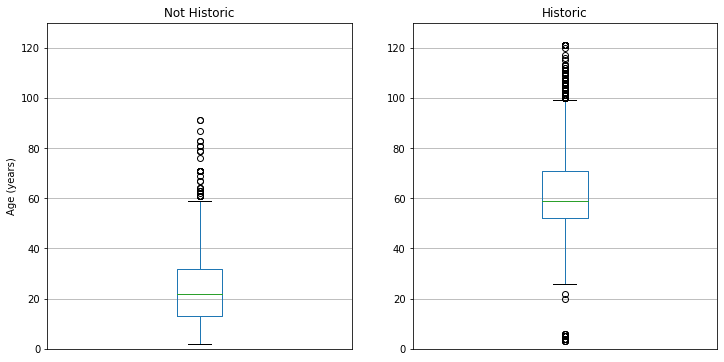

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, (a1, a2) = plt.subplots(1,2, figsize=(12,6))

not_historic.boxplot(column='Age', ax=a1, )
historic.boxplot(column='Age', ax=a2)

a1.set_ylabel('Age (years)')
a1.set_xticks([])
a2.set_xticks([])
a1.set_ylim(0, 130)
a2.set_ylim(0, 130)
a1.set_title('Not Historic')
a2.set_title('Historic')

In [6]:
historic.Age.describe()

count    14323.000000
mean        63.188019
std         14.638984
min          3.000000
25%         52.000000
50%         59.000000
75%         71.000000
max        121.000000
Name: Age, dtype: float64

In [7]:
q1_historic_age = historic.Age.quantile(0.25)
q3_historic_age = historic.Age.quantile(0.75)
iqr_historic_age = q3_historic_age - q1_historic_age
print(iqr_historic_age)

high_outliers = q3_historic_age + 1.5 * iqr_historic_age

print(high_outliers)

19.0
99.5


In [8]:
bridges = bridges[bridges['Age'] < high_outliers]
bridges

,District,Detour_Km,Toll,Maintainer,Urban,Status,Year,Lanes_on,Lanes_under,AverageDaily,...,Length,Width,Deck_rating,Superstr_rating,Substr_rating,Rated_load,Trucks_percent,Scour_rating,Future_traffic,Age
Structure_id,,,,,,,,,,,,,,,,,,,,,
000021521-00101,District2,199,Free,Agency,Rural,Local,2005,1,0,1,...,31.4,4.3,Good,Very Good,Very Good,41.7,0.0,Dry,1,16
000021521-00181,District2,199,Free,Agency,Rural,Local,2005,1,0,1,...,15.5,4.3,Good,Good,Very Good,41.7,0.0,Dry,1,16
000021521-TMP20,District2,199,Free,Agency,Rural,Local,2012,2,0,100,...,10.1,8.4,Very Good,Very Good,Very Good,48.1,0.0,Dry,150,9
000021525-00012,District2,199,Free,Agency,Rural,Local,1950,1,0,80,...,45.4,3.7,Good,Good,Poor,10.0,0.0,Dry,120,71
000021580-00092,District2,6,Free,Agency,Rural,Local,2004,2,0,150,...,25.0,7.3,Good,Very Good,Very Good,37.2,4.0,Dry,200,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DAPFORHOO000012,District9,0,Free,Military,Urban,Local,1994,3,0,300,...,45.4,19.0,Good,Good,Good,64.3,40.0,No waterway,600,27
DAPFORHOO000013,District9,0,Free,Military,Urban,Local,2000,2,0,300,...,12.3,10.8,Good,Good,Good,35.1,40.0,No waterway,600,21
DAPFORHOO000015,District9,0,Free,Military,Urban,Minor,1996,2,7,1200,...,73.2,9.8,Good,Good,Good,24.5,25.0,No waterway,1500,25


### Section 2.2: Treatment of Remaining Outliers

**Exploring outliers from AverageDaily and Trucks_percent variables**

  * Plotting boxplots of AverageDaily and Trucks_percent showed many outliers for both variables. I determined that the number of outliers for AverageDaily was 3478 and for Trucks_percent was 1295. Since there was such a large number of outliers in these variables, accounting for 4751 bridges, or more than 13% of the total dataset, I decided not to exclude these outliers from the analysis. 

Text(0.5, 1.0, 'Percent Trucks')

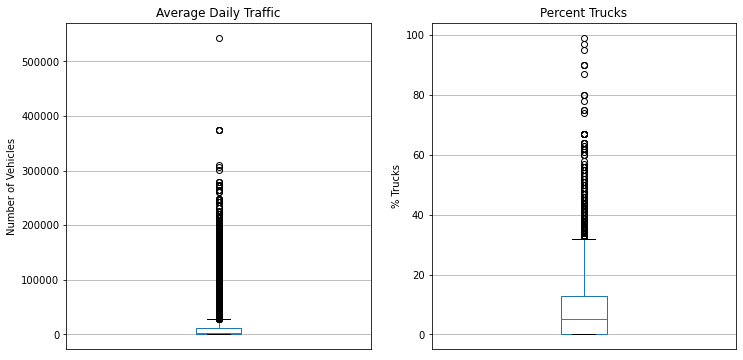

In [9]:
fig, (a1, a2) = plt.subplots(1,2, figsize=(12,6))

bridges.boxplot(column='AverageDaily', ax=a1, )
bridges.boxplot(column='Trucks_percent', ax=a2, )

a1.set_ylabel('Number of Vehicles')
a2.set_ylabel('% Trucks')
a1.set_xticks([])
a2.set_xticks([])
a1.set_title('Average Daily Traffic')
a2.set_title('Percent Trucks')

In [10]:
bridges.AverageDaily.describe()

count     34117.000000
mean      11669.382243
std       24280.770547
min           0.000000
25%         340.000000
50%        3300.000000
75%       11900.000000
max      543000.000000
Name: AverageDaily, dtype: float64

In [11]:
q1_averagedaily = bridges.AverageDaily.quantile(0.25)
q3_averagedaily = bridges.AverageDaily.quantile(0.75)
iqr_averagedaily = q3_averagedaily - q1_averagedaily
print(iqr_averagedaily)

high_outliers_ad = q3_averagedaily + 1.5 * iqr_averagedaily

print(high_outliers_ad)

11560.0
29240.0


In [12]:
bridges.Trucks_percent.describe()

count    34117.000000
mean         8.605475
std         10.356776
min          0.000000
25%          0.000000
50%          5.000000
75%         13.000000
max         99.000000
Name: Trucks_percent, dtype: float64

In [13]:
q1_trucks_percent = bridges.Trucks_percent.quantile(0.25)
q3_trucks_percent = bridges.Trucks_percent.quantile(0.75)
iqr_trucks_percent = q3_trucks_percent - q1_trucks_percent
print(iqr_trucks_percent)

high_outliers_tp = q3_trucks_percent + 1.5 * iqr_trucks_percent

print(high_outliers_tp)

13.0
32.5


In [14]:
print(f"The AverageDaily variable includes {len(bridges[bridges['AverageDaily'] > high_outliers_ad])} outliers.")
print(f"The Trucks_percent variable includes {len(bridges[bridges['Trucks_percent'] > high_outliers_tp])} outliers.")

The AverageDaily variable includes 3478 outliers.
The Trucks_percent variable includes 1295 outliers.


In [15]:
len(bridges[(bridges['AverageDaily'] > high_outliers_ad) | (bridges['Trucks_percent'] > high_outliers_tp)])

4751

In [16]:
print(f"Combined, these outliers account for {int(100 * (4751) / len(bridges.District))}% of the entire dataset")

Combined, these outliers account for 13% of the entire dataset


### Section 2.3: Simplified Material and Design

**Creating simplified variables for Material and Design involved aggregating classes that classified fewer than 1% of all bridges into the next smallest class**

  * I first determined the value of 1% of the total number of bridges (341).
  * I then compared the value counts for classes in the existing Material feature to determine which classes classified less than 1% of bridges (Masonry = 10; Other = 48) and combined these classes with the next smallest class (Timber = 465).
  * I then compared the value counts for classes in the existing Design feature to determine which classes classified less than 1% of bridges (Suspension = 5; Movable = 13; Frame = 68; Truss = 100; Arch = 139) and combined these classes with the next smallest class (Other = 1243).

In [17]:
print(f'{int(len(bridges.District) * 0.01)} bridges account for 1% of all bridges')

341 bridges account for 1% of all bridges


In [18]:
bridges.Material.value_counts()

Concrete    27023
Steel        6571
Timber        465
Other          48
Masonry        10
Name: Material, dtype: int64

In [19]:
def remove_infrequent_materials(bridge):
    if bridge.Material == 'Concrete' or bridge.Material == 'Steel':
        return bridge.Material
    else:
        return 'Timber_or_Other'
    
bridges = bridges.assign(Material_simplified = bridges.apply(remove_infrequent_materials, axis = 1))
bridges.Material_simplified.value_counts()

Concrete           27023
Steel               6571
Timber_or_Other      523
Name: Material_simplified, dtype: int64

In [20]:
bridges.Design.value_counts()

Beam          28263
Slab           4286
Other          1243
Arch            139
Truss           100
Frame            68
Movable          13
Suspension        5
Name: Design, dtype: int64

In [21]:
def remove_infrequent_designs(bridge):
    if bridge.Design == 'Beam' or bridge.Design == 'Slab':
        return bridge.Design
    else:
        return 'Other_Design'
    
bridges = bridges.assign(Design_simplified = bridges.apply(remove_infrequent_designs, axis = 1))
bridges.Design_simplified.value_counts()

Beam            28263
Slab             4286
Other_Design     1568
Name: Design_simplified, dtype: int64

### Section 2.4: Current Condition

**Combine the three main condition variables (Deck_rating, Superstr_rating, and Substr_rating), by treating each as an integer score (0 for failed to 10 for Excellent) and adding the three scores to create a new Current_Condition target variable**

  * I first removed any bridges that contained null values for any target or predictor variable (only Deck_rating and Superstr_rating contained null values).
  * I then created an integer score system for the Deck_rating, Superstr_rating, and Substr_rating variables ('Failed':0, 'Failing':1, 'Critical':2, 'Serious':3, 'Serious':4, 'Poor':5, 'Fair':6, 'Satisfactory': 7, 'Good':8, 'Very Good':9, 'Excellent':10) and applied it to all three variables, summing the scores for each bridge in a new target variable called Current_Condition.
  * Finally, I reduced the dataframe to only the variables relevant to the regression analysis (Current_Condition, AverageDaily, Trucks_percent, Age, Material_simplified, Design_simplified).

In [22]:
bridges.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34117 entries, 000021521-00101 to DAPTRABLI000011
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   District             34117 non-null  category
 1   Detour_Km            34117 non-null  int64   
 2   Toll                 34117 non-null  category
 3   Maintainer           34117 non-null  category
 4   Urban                34117 non-null  category
 5   Status               34117 non-null  category
 6   Year                 34117 non-null  int64   
 7   Lanes_on             34117 non-null  int64   
 8   Lanes_under          34117 non-null  int64   
 9   AverageDaily         34117 non-null  int64   
 10  Historic             34117 non-null  category
 11  Service_under        34117 non-null  category
 12  Material             34117 non-null  category
 13  Design               34117 non-null  category
 14  Spans                34117 non-null  int64   
 15  

In [23]:
deck_super_na = bridges.loc[(bridges.Deck_rating.isnull()) | (bridges.Superstr_rating.isnull())]
bridges = bridges.drop(deck_super_na.index)

In [24]:
def sum_bridge_rating(bridge):
    rating_dict = {'Failed':0, 'Failing':1, 'Critical':2, 'Serious':3, 'Serious':4, 'Poor':5, 'Fair':6, 'Satisfactory': 7, 
                   'Good':8, 'Very Good':9, 'Excellent':10}
    
    return rating_dict[bridge.Deck_rating] + rating_dict[bridge.Superstr_rating] + rating_dict[bridge.Substr_rating]

bridges = bridges.assign(Current_Condition = bridges.apply(sum_bridge_rating, axis=1))

In [25]:
cols = [ 'Current_Condition','AverageDaily', 'Trucks_percent', 'Age','Material_simplified', 'Design_simplified']

bridges = bridges.loc[:, cols]

bridges.head()

,Current_Condition,AverageDaily,Trucks_percent,Age,Material_simplified,Design_simplified
Structure_id,,,,,,
000021521-00101,26,1,0.0,16,Concrete,Slab
000021521-00181,25,1,0.0,16,Concrete,Slab
000021521-TMP20,27,100,0.0,9,Concrete,Beam
000021525-00012,21,80,0.0,71,Timber_or_Other,Beam
000021580-00092,26,150,4.0,17,Concrete,Beam


## Section 3: Exploratory Analysis


### Section 3.1: Comparisons of Continuous Variables

  * To compare the continous variables (Current_Condition, AverageDaily, Trucks_percent, Age), I plotted a scatter matrix of the data. I also created a correlation matrix to help verify any observed correlations from the plot.
  
**Preliminary Conclusions:**
  
  * There appears to be a negative correlation between Current_Condition and Age, with the newest bridges (0-10 years) having generally higher Current_Condition scores which generally decline for older bridges. A correlation coefficient of -0.59 supports a moderate correlation as was visualized in the plot.
  * There is also quite a weak correlation between Age and Trucks_percent of 0.23, but this is difficult to visualize in the plot.
  * No other clear correlations between continous variables appear in the plots or in the correlation matrix.
  * From the histograms, Current_condition appears to have a somewhat normal distribution, while the remaining continous variables each have a positive skew.

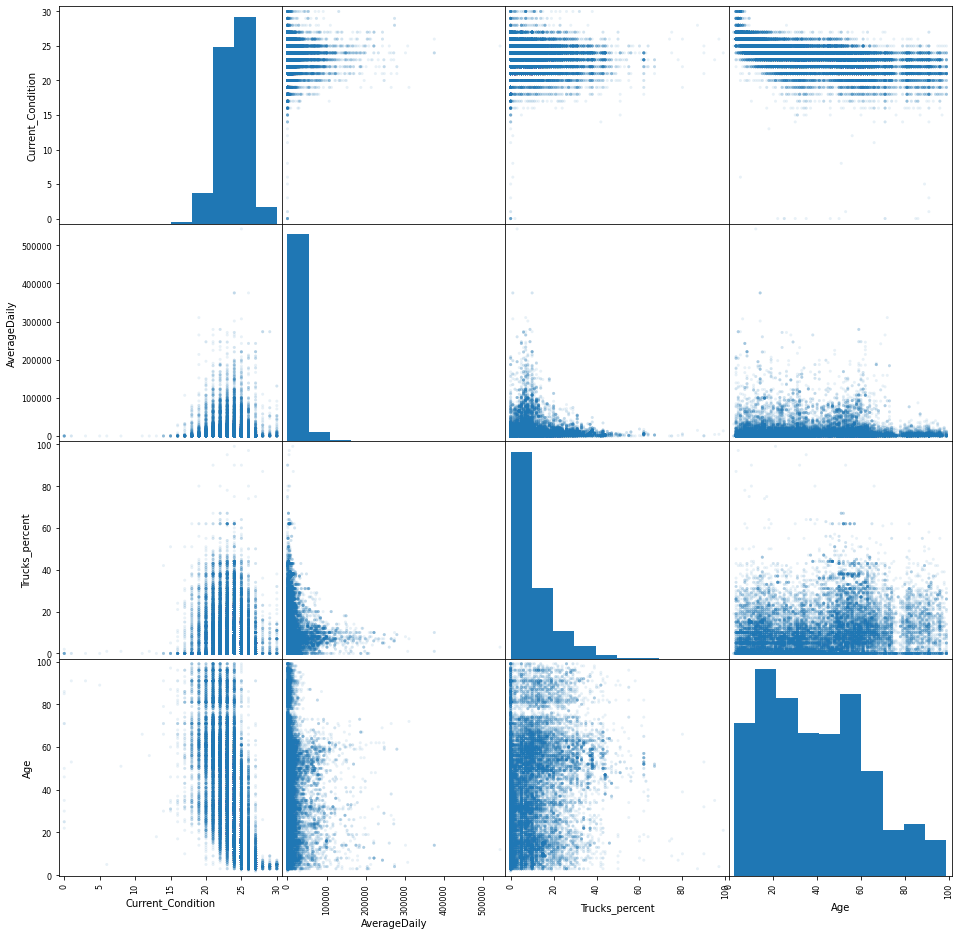

In [26]:
_a = pd.plotting.scatter_matrix(bridges, figsize=(16,16), alpha=0.1)

In [27]:
bridges.corr()

,Current_Condition,AverageDaily,Trucks_percent,Age
Current_Condition,1.000000,0.035728,-0.047528,-0.586652
AverageDaily,0.035728,1.000000,0.022443,-0.054209
Trucks_percent,-0.047528,0.022443,1.000000,0.227831
Age,-0.586652,-0.054209,0.227831,1.000000


### Section 3.2: Comparisons between Continous and Categorical Variables

  * To observe the different ranges of Current_Condition values according to categorical variables for bridge material and design, I plotted boxplots for Current_Condition vs. Material_simplified and vs. Design_simplified.
  * To observe the different Age ranges according to categorical variables for bridge material and design, I plotted boxplots for Age vs. Material_simplified and vs. Design_simplified.
  * To observe the different ranges of the average number of vehicles according to categorical variables for bridge material and design, I plotted boxplots for AverageDaily vs. Material_simplified and vs. Design_simplified. I also created a second plot to observe the boxplots without the large number of outliers in the first plot.
  * To observe the different ranges of percentages of trucks according to categorical variables for bridge material and design, I plotted boxplots for Trucks_percent vs. Material_simplified and vs. Design_simplified. I also created a second plot to observe the boxplots without the large number of outliers in the first plot.
  * To support any observations from the plots, I also produced tables containing means and standard deviations, min and max values, and quartiles for each continuous variable grouped by each class in the categorical variables.
  
**Preliminary Conclusions:**

  * Because of high variability relative to any differences observed between means in the continous variables, any of the relationships described below are unlikely to be significant, but observations are described nonetheless.
  * Concrete and steel bridges appear to have generally higher current condition scores compared to bridges made from other materials, with concrete having the highest scores.
  * In general slab bridges appear to have slightly lower current condition scores compared to beam or other designs.
  * The age range for bridges made from concrete and steel is similar while bridges made from other materials are generally newer.
  * The age range of slab bridges is generally older than beam or other designs. The age range of beam bridges is generally slightly older than other designs.
  * Concrete bridges see the most traffic, followed by steel. Timber and other bridges see very low traffic relative to concrete and steel.
  * Beam bridges see the most traffic, followed by slab and then other designs.
  * Concrete bridges have the highest percentage of trucks as traffic, followed by steel. Timber and other bridges have very low percentages of trucks relative to concrete and steel.
  * Slab bridges appear to have the highest percentage of trucks as traffic, followed by beam and then other designs.

Text(0, 0.5, 'Current Condition')

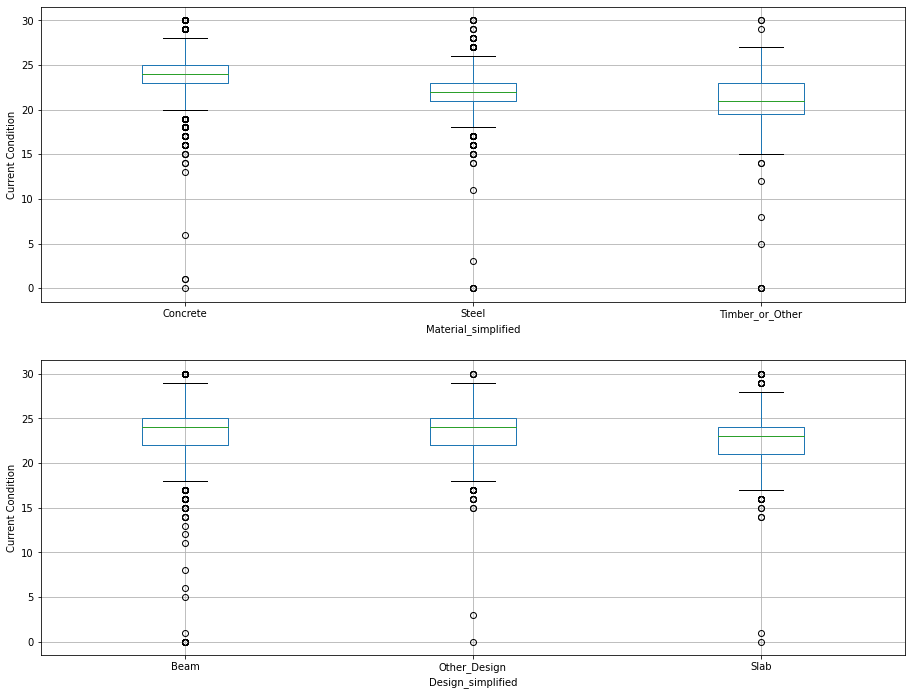

In [28]:
fig, (a1, a2) = plt.subplots(2,1, figsize=(15,12))

bridges.boxplot(column='Current_Condition', by='Material_simplified', ax=a1)
bridges.boxplot(column='Current_Condition', by='Design_simplified', ax=a2)

fig.suptitle('')
[a.set_title('') for a in [a1, a2]]
a1.set_ylabel('Current Condition')
a2.set_ylabel('Current Condition')

In [29]:
bridges.groupby('Material_simplified')['Current_Condition'].describe()

,count,mean,std,min,25%,50%,75%,max
Material_simplified,,,,,,,,
Concrete,27018.0,23.661152,1.829551,0.0,23.0,24.0,25.0,30.0
Steel,6569.0,22.075658,1.947288,0.0,21.0,22.0,23.0,30.0
Timber_or_Other,523.0,20.799235,3.310242,0.0,19.5,21.0,23.0,30.0


In [30]:
bridges.groupby('Design_simplified')['Current_Condition'].describe()

,count,mean,std,min,25%,50%,75%,max
Design_simplified,,,,,,,,
Beam,28261.0,23.392661,1.948666,0.0,22.0,24.0,25.0,30.0
Other_Design,1563.0,23.537428,2.613194,0.0,22.0,24.0,25.0,30.0
Slab,4286.0,22.697387,2.040118,0.0,21.0,23.0,24.0,30.0


Text(0, 0.5, 'Age')

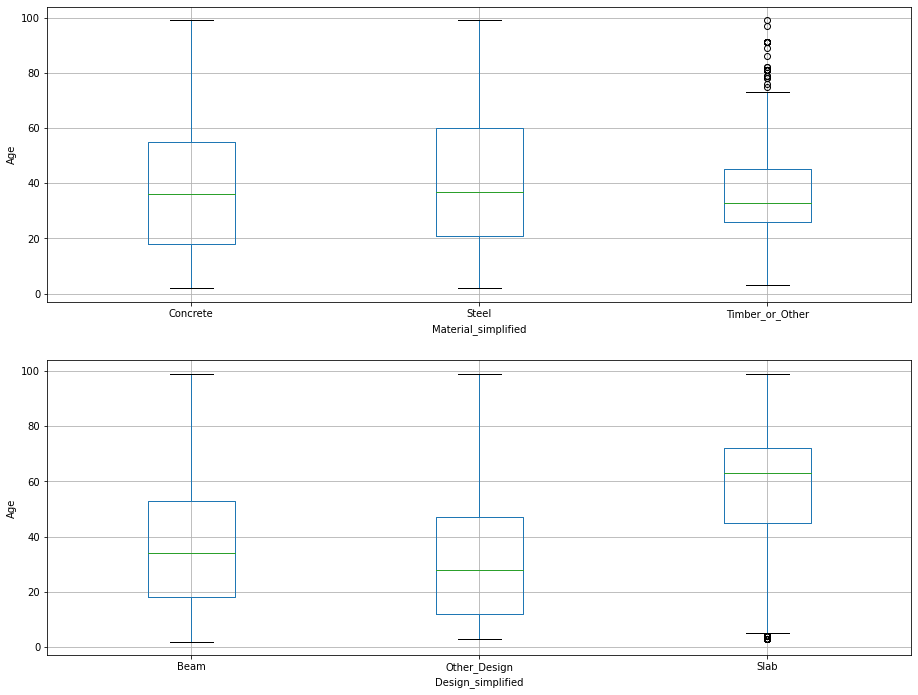

In [31]:
fig, (a1, a2) = plt.subplots(2,1, figsize=(15,12))

bridges.boxplot(column='Age', by='Material_simplified', ax=a1)
bridges.boxplot(column='Age', by='Design_simplified', ax=a2)

fig.suptitle('')
[a.set_title('') for a in [a1, a2]]
a1.set_ylabel('Age')
a2.set_ylabel('Age')

In [32]:
bridges.groupby('Material_simplified')['Age'].describe()

,count,mean,std,min,25%,50%,75%,max
Material_simplified,,,,,,,,
Concrete,27018.0,38.404656,23.289240,2.0,18.0,36.0,55.0,99.0
Steel,6569.0,42.404323,24.128659,2.0,21.0,37.0,60.0,99.0
Timber_or_Other,523.0,37.904398,19.618840,3.0,26.0,33.0,45.0,99.0


In [33]:
bridges.groupby('Design_simplified')['Age'].describe()

,count,mean,std,min,25%,50%,75%,max
Design_simplified,,,,,,,,
Beam,28261.0,36.839602,22.006912,2.0,18.0,34.0,53.0,99.0
Other_Design,1563.0,32.506078,24.451587,3.0,12.0,28.0,47.0,99.0
Slab,4286.0,56.944470,24.473713,3.0,45.0,63.0,72.0,99.0


Text(0, 0.5, 'Average Number of Vehicles Daily')

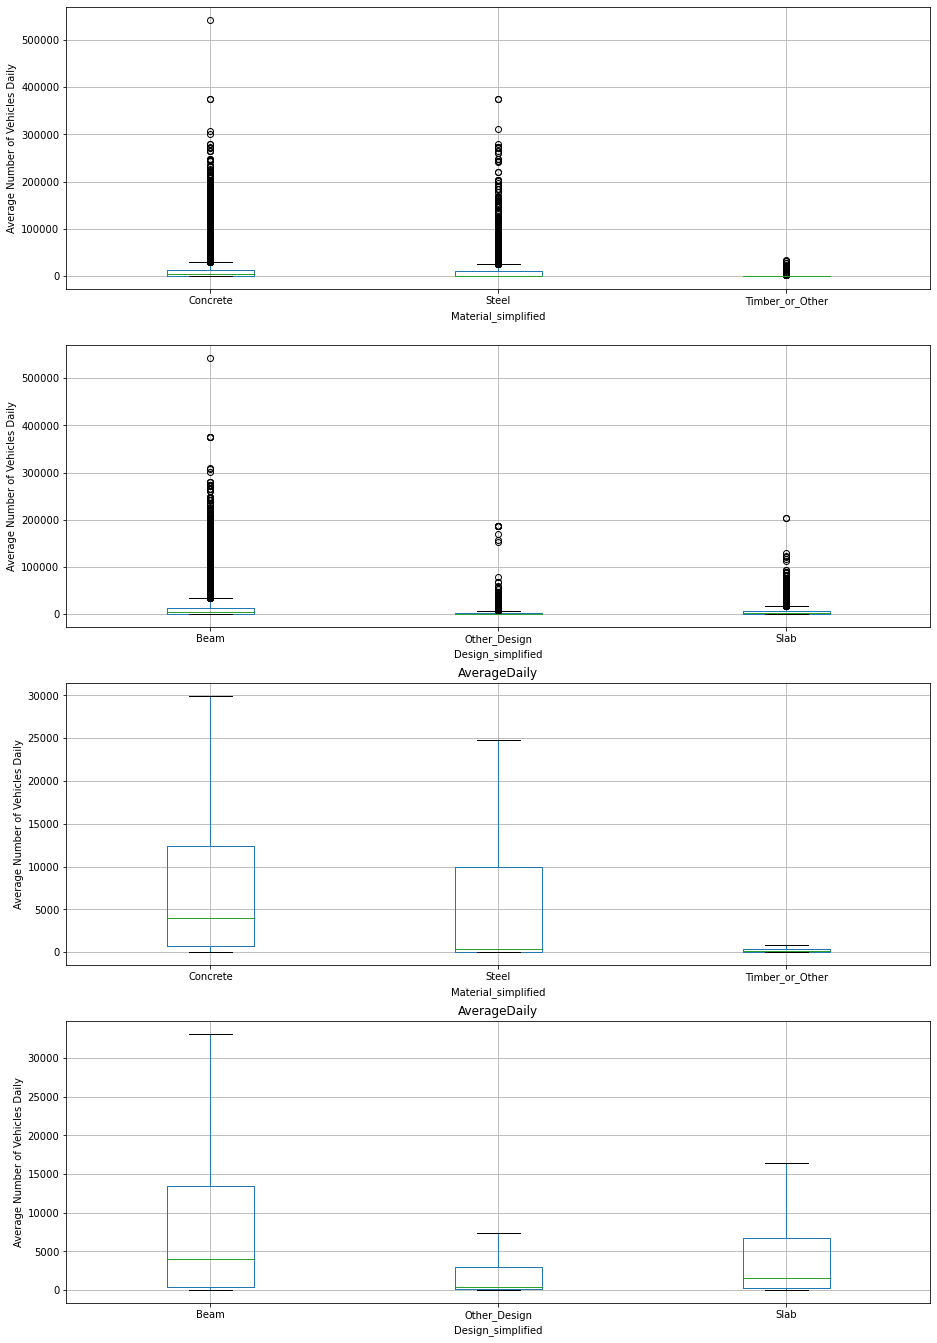

In [34]:
fig, (a1, a2, a3, a4) = plt.subplots(4,1, figsize=(15,24))

bridges.boxplot(column='AverageDaily', by='Material_simplified', ax=a1)
bridges.boxplot(column='AverageDaily', by='Design_simplified', ax=a2)
bridges.boxplot(column='AverageDaily', by='Material_simplified', ax=a3, showfliers=False)
bridges.boxplot(column='AverageDaily', by='Design_simplified', ax=a4, showfliers=False)

fig.suptitle('')
[a.set_title('') for a in [a1, a2]]
a1.set_ylabel('Average Number of Vehicles Daily')
a2.set_ylabel('Average Number of Vehicles Daily')
a3.set_ylabel('Average Number of Vehicles Daily')
a4.set_ylabel('Average Number of Vehicles Daily')

In [35]:
bridges.groupby('Material_simplified')['AverageDaily'].describe()

,count,mean,std,min,25%,50%,75%,max
Material_simplified,,,,,,,,
Concrete,27018.0,11975.917129,23681.545367,0.0,670.0,4030.0,12377.5,543000.0
Steel,6569.0,11269.802253,27288.818373,0.0,60.0,403.0,10000.0,375126.0
Timber_or_Other,523.0,993.124283,3571.396687,2.0,50.0,100.0,393.5,33500.0


In [36]:
bridges.groupby('Design_simplified')['AverageDaily'].describe()

,count,mean,std,min,25%,50%,75%,max
Design_simplified,,,,,,,,
Beam,28261.0,12983.718800,25835.697604,1.0,420.0,4000.0,13500.0,543000.0
Other_Design,1563.0,4279.423544,15217.646767,0.0,90.0,385.0,2990.0,187220.0
Slab,4286.0,5714.990201,11848.237855,1.0,290.0,1580.0,6750.0,203800.0


Text(0, 0.5, 'Percent Truck Traffic')

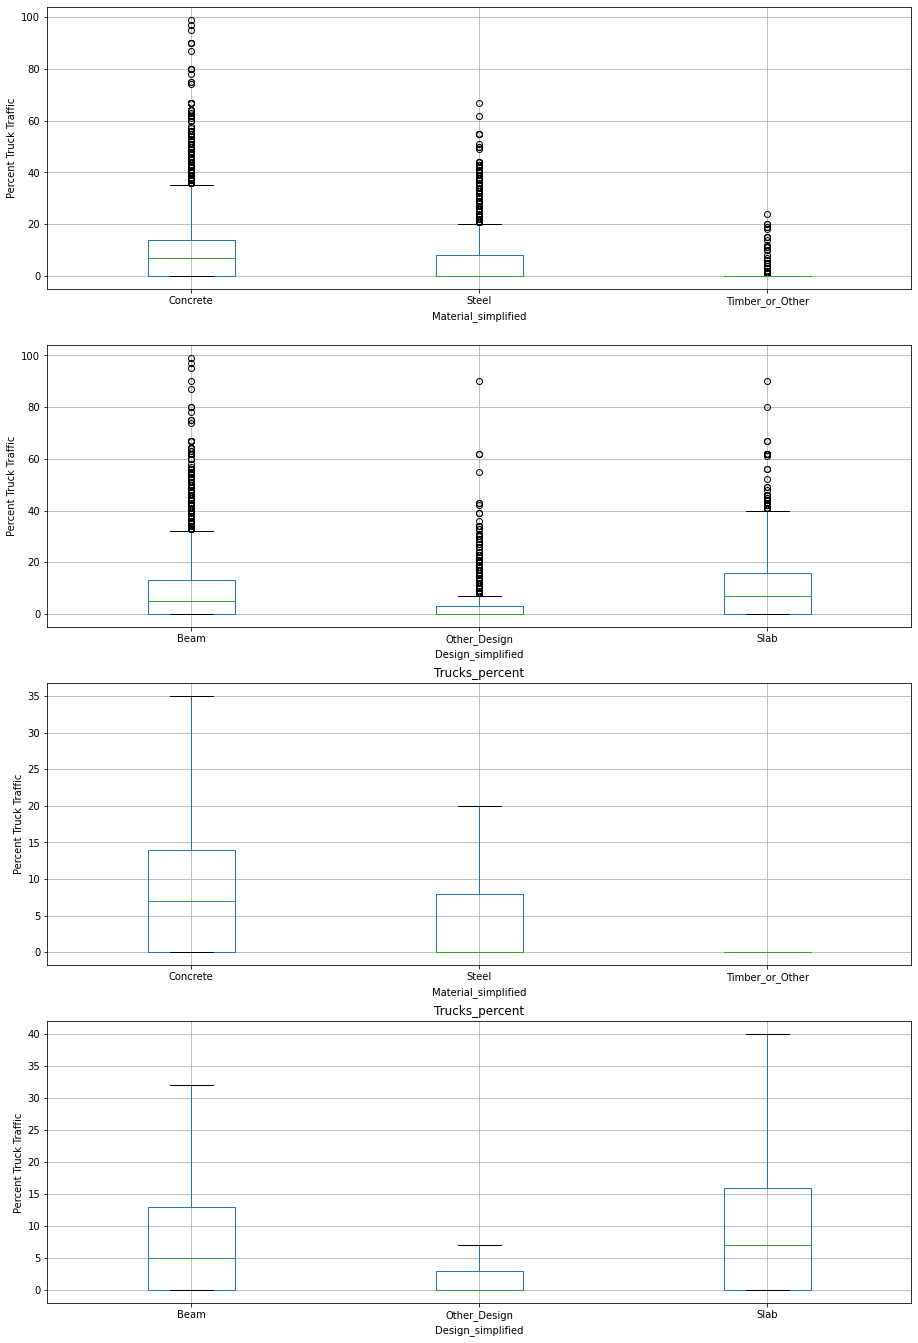

In [37]:
fig, (a1, a2, a3, a4) = plt.subplots(4,1, figsize=(15,24))

bridges.boxplot(column='Trucks_percent', by='Material_simplified', ax=a1)
bridges.boxplot(column='Trucks_percent', by='Design_simplified', ax=a2)
bridges.boxplot(column='Trucks_percent', by='Material_simplified', ax=a3, showfliers=False)
bridges.boxplot(column='Trucks_percent', by='Design_simplified', ax=a4, showfliers=False)

fig.suptitle('')
[a.set_title('') for a in [a1, a2]]
a1.set_ylabel('Percent Truck Traffic')
a2.set_ylabel('Percent Truck Traffic')
a3.set_ylabel('Percent Truck Traffic')
a4.set_ylabel('Percent Truck Traffic')

In [38]:
bridges.groupby('Material_simplified')['Trucks_percent'].describe()

,count,mean,std,min,25%,50%,75%,max
Material_simplified,,,,,,,,
Concrete,27018.0,9.521689,10.623125,0.0,0.0,7.0,14.0,99.0
Steel,6569.0,5.453798,8.609316,0.0,0.0,0.0,8.0,67.0
Timber_or_Other,523.0,0.940727,2.949499,0.0,0.0,0.0,0.0,24.0


In [39]:
bridges.groupby('Design_simplified')['Trucks_percent'].describe()

,count,mean,std,min,25%,50%,75%,max
Design_simplified,,,,,,,,
Beam,28261.0,8.675701,10.270322,0.0,0.0,5.0,13.0,99.0
Other_Design,1563.0,3.314139,7.058053,0.0,0.0,0.0,3.0,90.0
Slab,4286.0,10.081895,11.298457,0.0,0.0,7.0,16.0,90.0


### Section 3.2: Comparison between Categorical Variables

  * To observe the relationships between the two categorical variables Materail_simplified and Design_simplified, I plotted bar charts of the proportion of each material type vs. design type and vice versa.
  
**Preliminary Conclusions:**

  * Concrete is by far the predominant material used for all bridge design types, and the only material type used in slab bridges. Steel is the next most common material for beam and other designs, while timber or other is the least common material.
  * Beam bridges are the most common design type for all bridge material types. Slab bridges only occur with concrete bridges, and are the second most common design for concrete bridges. Other designs are the second most common design type for steel and timber or other bridges, and the third most common for concrete bridges.

Text(0, 0.5, 'Proportion of Design Type')

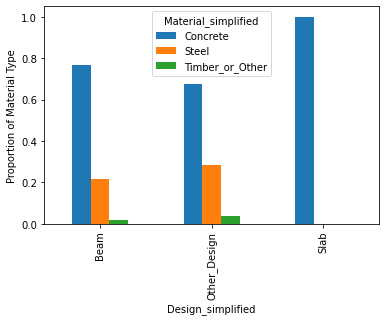

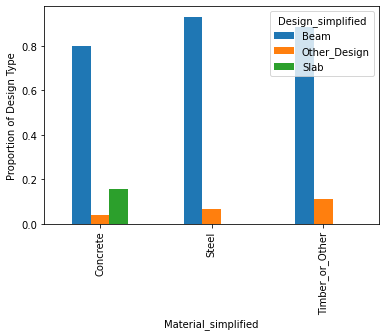

In [40]:
design_material = pd.crosstab(bridges.Design_simplified, [bridges.Material_simplified], normalize='index')
material_design = pd.crosstab(bridges.Material_simplified, [bridges.Design_simplified], normalize='index')

ax1 = design_material.plot(kind='bar')
ax1.set_ylabel('Proportion of Material Type')

ax2 = material_design.plot(kind='bar')
ax2.set_ylabel('Proportion of Design Type')

## Section 4: Regression Analysis

In this section I carry out a multiple linear regression to create a model that predicts the target variable (Current_Condition) based on predictor variables (AverageDaily, Trucks_percent, Age, Material_simplified, observe the regression coefficients of the predictors, and Design_simplified), interpret how these predictor variables influence the target variable, and observe the model error to quantify its quality.

### Section 4.1: Conversion of Categorical Variables to Numeric

  * Here, I convert the categorical variables, Material_simplified and Design_simplifed into binary representations of each class in each variable in order to include these variables in the regression.

In [41]:
dummy_material = pd.get_dummies(bridges['Material_simplified'])
dummy_design = pd.get_dummies(bridges['Design_simplified'])

bridges = pd.concat([bridges, dummy_material, dummy_design], axis=1)
bridges = bridges.drop('Material_simplified',axis=1)
bridges = bridges.drop('Design_simplified',axis=1)

bridges.head()

,Current_Condition,AverageDaily,Trucks_percent,Age,Concrete,Steel,Timber_or_Other,Beam,Other_Design,Slab
Structure_id,,,,,,,,,,
000021521-00101,26,1,0.0,16,1,0,0,0,0,1
000021521-00181,25,1,0.0,16,1,0,0,0,0,1
000021521-TMP20,27,100,0.0,9,1,0,0,1,0,0
000021525-00012,21,80,0.0,71,0,0,1,1,0,0
000021580-00092,26,150,4.0,17,1,0,0,1,0,0


### Section 4.2: Multiple Linear Regression

  * Here I carry out the linear regression using variables: 
    * AverageDaily
    * Trucks_percent
    * Age
    * Concrete
    * Steel
    * Beam
    * Slab
  
  * Timber_or_Other and Other_Design variables are omitted as references to avoid collinearity between classes of material and design and also to act as a comparison for the classes that were used. I chose to include concrete and steel material classes because they are most common and because they are likely to be of most interest to the bridge expert. I chose to include beam and slab design classes because they are most common.

In [42]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [43]:
y = bridges.Current_Condition # this is the target variable; we assue just one though more are possible
X = np.column_stack((bridges.AverageDaily,bridges.Trucks_percent,bridges.Age,bridges.Concrete,
                     bridges.Steel,bridges.Beam,bridges.Slab))
X[0:5]

array([[  1.,   0.,  16.,   1.,   0.,   0.,   1.],
       [  1.,   0.,  16.,   1.,   0.,   0.,   1.],
       [100.,   0.,   9.,   1.,   0.,   1.,   0.],
       [ 80.,   0.,  71.,   0.,   0.,   1.,   0.],
       [150.,   4.,  17.,   1.,   0.,   1.,   0.]])

In [44]:
reg = LinearRegression().fit(X, y)

### Section 4.3: Regression Results

  * Here, the R2 coefficient of determination, the intercept, and regression coefficients for each predictor are presented.
  * The range of each continous variable (Current_Condtion, AverageDaily, Trucks_percent, and Age) is quantified as the range between the 10% to 90% quantiles. I then compute the change in the target variable Current condition, as a percentage of its range, resulting from a change in each continous predictor variable over its range.
  * I then compute the change in the target variable Current condition, as a percentage of its range, resulting from the presence of each material and design class used in the regression vs. the reference classes that were ommitted.
  * I then computed and plotted the residuals and computed the Root Mean Squared Error.
  * Finally, I plotted the linear regression model along with the predicted and actual Current_Condition values.
  
**Variance Explained by Model and Influence of Predictors on Target Variable**

  * R2: the model coefficient of determination measures the proportion of variance explained by the model. The regression R2 value of the model was 0.445, so the predictor variables used explain 44.5% of the variance in current condition of the bridges.
  * The change in the target variable, current condition, as a percentage of its range (range = 5 value points), resulting from a change in each predictor variable is as follows (a 20% change is equivalent to 1 value point):
    * -59.8 percent per 61 year difference in bridge age
    * -0.4 percent per addition of 29670 vehicles
    * 2.5 percent per 23 percent increase in proportion of trucks
    * 57.3 percent for bridges built with concrete
    * 29.7 percent for bridges built with steel
    * -2.2 percent for beam bridges
    * -3.6 percent for slab bridges
  * Only three predictor variables: age, concrete, and steel; have a sufficient impact on current condition to change its value by even one point. 
    * A bridge 61 years older than another would on average have a current condition score approximately 3 value points lower.
    * A bridge built with concrete would on average have a current condition score approximately 3 value points higher than a bridge built with timber or other material.
    * A bridge built with steel would on average have a current condition score approximately 1.5 value points higher than bridge built with timber or other material.

**Error**

  * The scatter plot of actual vs. predicted values for current condition (black points) with the model (blue line) also plotted shows that nearly all of the values were predicted to within 5 value points of the actual current condition.
  * Residuals measure the difference between the predicted current condition and actual current condition for each bridge. The plot shows that the residuals appear to be normally distributed with a high peak at 0, indicating that the model predicted about 70% of bridges to within one or two value points of the actual current condition.  
  * The small number of bridges with current conditions < 15 tended to have larger residuals than bridges with higher current condition values, and those near failure (0) are generally predicted between 19 and 23.
  * The root mean squared error (RMSE) of the model was calculated to be 1.5 which corresponds to 1.5 current condition value points. RMSE is a measure of the standard deviation of the unexplained variance, so RMSE of 1.5 suggests that about 68% of samples were predicted to within 1.5 current condition value points (supporting the interpretation of the plotted residuals).

In [45]:
print('The R2 coefficient of determination is %4.3f' % reg.score(X, y))
print('The intercept is %4.1f' % reg.intercept_)
beta_average_daily, beta_trucks_percent, beta_age, beta_concrete, beta_steel, beta_beam, beta_slab = reg.coef_
print('Estimated regression coefficient for Average Daily Traffic is %4.3f' % (beta_average_daily*1000), 
      'change in Bridge Rating per 1,000 vehicles')
print('Estimated regression coefficient for Percent Trucks is %4.3f' % beta_trucks_percent, 
      'change in Bridge Rating per 1% increase in truck traffic')
print('Estimated regression coefficient for Age is %4.3f' % beta_age, 
      'change in Bridge Rating per year')
print('Estimated regression coefficient for Concrete Bridges is %4.3f' % beta_concrete, 
      'change in Bridge Rating for bridges constructed from concrete')
print('Estimated regression coefficient for Steel Bridges is %4.3f' % beta_steel, 
      'change in Bridge Rating for bridges constructed from steel')
print('Estimated regression coefficient for Beam Bridges is %4.3f' % beta_beam, 
      'change in Bridge Rating for bridges with a beam design')
print('Estimated regression coefficient for Slab Bridges is %4.3f' % beta_slab, 
      'change in Bridge Rating for bridges with a slab design')

The R2 coefficient of determination is 0.445
The intercept is 22.8
Estimated regression coefficient for Average Daily Traffic is -0.001 change in Bridge Rating per 1,000 vehicles
Estimated regression coefficient for Percent Trucks is 0.006 change in Bridge Rating per 1% increase in truck traffic
Estimated regression coefficient for Age is -0.049 change in Bridge Rating per year
Estimated regression coefficient for Concrete Bridges is 2.865 change in Bridge Rating for bridges constructed from concrete
Estimated regression coefficient for Steel Bridges is 1.484 change in Bridge Rating for bridges constructed from steel
Estimated regression coefficient for Beam Bridges is -0.111 change in Bridge Rating for bridges with a beam design
Estimated regression coefficient for Slab Bridges is -0.179 change in Bridge Rating for bridges with a slab design


In [46]:
average_daily_range = bridges.AverageDaily.quantile(0.9) - bridges.AverageDaily.quantile(0.1)
trucks_percent_range = bridges.Trucks_percent.quantile(0.9) - bridges.Trucks_percent.quantile(0.1)
age_range = bridges.Age.quantile(0.9) - bridges.Age.quantile(0.1)

current_condition_range = bridges.Current_Condition.quantile(0.9) - bridges.Current_Condition.quantile(0.1)

print('Average daily traffic range (10th to 90th centile) is %3.1f' % average_daily_range, 'vehicles')
print('Percent trucks range (10th to 90th centile) is %3.1f' % trucks_percent_range, '%')
print('Age range (10th to 90th centile) is %3.1f' % age_range, 'years')
print('Current condition range (10th to 90th centile) is %3.1f' % current_condition_range)

Average daily traffic range (10th to 90th centile) is 29670.0 vehicles
Percent trucks range (10th to 90th centile) is 23.0 %
Age range (10th to 90th centile) is 61.0 years
Current condition range (10th to 90th centile) is 5.0


In [47]:
print ('The change in current condition (as a percent of its range) given by the Average daily traffic coefficient (over its range) is %4.1f percent'
       % (100 * (beta_average_daily * average_daily_range) / current_condition_range))

print ('The change in current condition (as a percent of its range) given by the Percent trucks coefficient (over its range) is %4.1f percent'
       % (100 * (beta_trucks_percent * trucks_percent_range) / current_condition_range))

print ('The change in current condition (as a percent of its range) given by the Age coefficient (over its range) is %4.1f percent'
       % (100 * (beta_age * age_range) / current_condition_range))

The change in current condition (as a percent of its range) given by the Average daily traffic coefficient (over its range) is -0.4 percent
The change in current condition (as a percent of its range) given by the Percent trucks coefficient (over its range) is  2.5 percent
The change in current condition (as a percent of its range) given by the Age coefficient (over its range) is -59.8 percent


In [48]:
print ('The change in current condition (as a percent of its range) given by the Concrete coefficient (concrete vs. other) is %4.1f percent'
       % (100 * (beta_concrete) / current_condition_range))

print ('The change in current condition (as a percent of its range) given by the Steel coefficient (steel vs. other) is %4.1f percent'
       % (100 * (beta_steel) / current_condition_range))

print ('The change in current condition (as a percent of its range) given by the Beam coefficient (beam vs. other) is %4.1f percent'
       % (100 * (beta_beam) / current_condition_range))

print ('The change in current condition (as a percent of its range) given by the Slab coefficient (slab vs. other) is %4.1f percent'
       % (100 * (beta_slab) / current_condition_range))

The change in current condition (as a percent of its range) given by the Concrete coefficient (concrete vs. other) is 57.3 percent
The change in current condition (as a percent of its range) given by the Steel coefficient (steel vs. other) is 29.7 percent
The change in current condition (as a percent of its range) given by the Beam coefficient (beam vs. other) is -2.2 percent
The change in current condition (as a percent of its range) given by the Slab coefficient (slab vs. other) is -3.6 percent


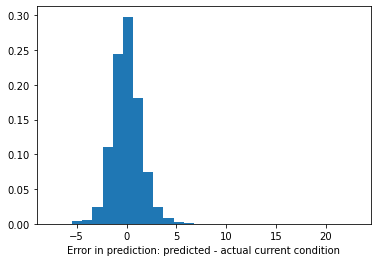

In [49]:
y_hat = reg.predict(X)

fig, a1 = plt.subplots(1, 1)
residuals = y_hat - y
a1.hist(residuals, bins=30, density=True)
_ = a1.set_xlabel('Error in prediction: predicted - actual current condition')

In [50]:
print('Root of the mean squared error: %.2f'% mean_squared_error(y, y_hat, squared=False))

Root of the mean squared error: 1.50


Text(0, 0.5, 'Actual Value')

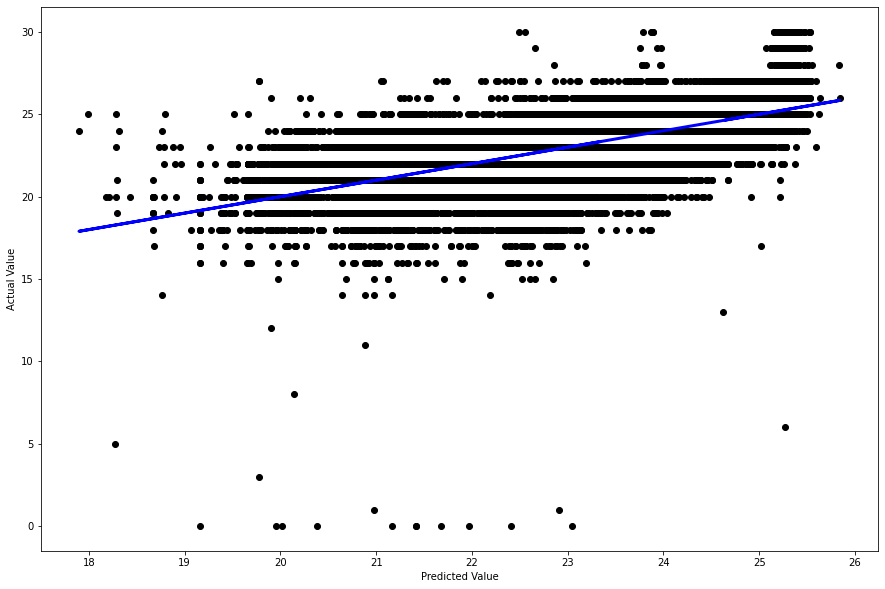

In [51]:
# Plot outputs
fig, a = plt.subplots(1,1,figsize=(15,10))
a.scatter(y_hat, y,  color='black')
a.plot(y_hat, y_hat, color='blue', linewidth=3)

# two_std = residuals.std() * 2
# a.errorbar(y_hat, y, yerr=two_std, fmt='.k')

a.set_xlabel('Predicted Value')
a.set_ylabel('Actual Value')

### Section 4.4: Conclusions

The regression model predicts nearly half (44.5%) of the variation in the current condition variable and approximately 68% of bridges are predicted to within 1.5 points of their actual current conition values. The strongest predictors of current condition used in this analysis are age, with bridges losing about 3 points over 61 years, concrete, with bridges built with concrete having about 3 points more than the omitted timber or other class, and steel, with bridges built with steel having about 1.5 points more than the omitted timber or other class. The remaining predictors had little influence on current condition. Based on these results, building bridges with concrete appears to be the best intervention for improving current condition of bridges.

**Further Analysis**

I recommend analyzing the failing or failed bridges more closely to determine if there are any common factors that might contribute to their poor condition, especially as the model does a bad job of predicting these. It would also be interesting to see if the average daily vehicle traffic and percent trucks would have a more prominent influence on the current condition if the outliers for those variables were removed. Because there seems to be a correlation between design and materials, and because design has little influence on the regression, it may be better to try the regression without the design variables.